In [1]:
from itertools import chain
import os
from types import SimpleNamespace

import matplotlib.pyplot as plt
import numpy as np

from run_cifar10 import gen_sweep


In [2]:
def fetch_loss_prec(arch, data, modifier, hyperparms_list, fn_modifier=''):
    #save_dir = '{}_{}_ckpts'.format(arch, data)
    save_dir = '{}_{}{}_ckpts'.format(data, arch, modifier)
    batch_size = 128
    activation='relu'


    loss_s = {}
    prec_s = {}

    opts = ['ada','sgd','krad','kradmm','shampoo','kradapoo']
    for opt in opts:
        args_sweeps_list = [gen_sweep(x.__dict__) for x in hyperparms_list]
        args_sweeps = chain(*args_sweeps_list)

        loss_prec = 1  #loss=0; prec=1
        best = -np.inf if loss_prec else np.inf
        best_name = ''
        for args in args_sweeps:
            if args.optimizer != opt: continue
            opt_modifier_str = (
                '_eps{}_lr{}_batch{}'.format(
                    args.eps_str, args.lr_str, batch_size
                )
            ) + (
                '_soft' if activation=='softplus' else ''
            ) + fn_modifier
            loss_fn = os.path.join(save_dir, 'loss_{}{}.npy'.format(opt, opt_modifier_str))
            prec_fn = os.path.join(save_dir, 'prec_{}{}.npy'.format(opt, opt_modifier_str))
            
            try:
                loss_, prec_ = [np.load(x) for x in [loss_fn, prec_fn]]

                tr_or_va = 1  # train=0; validation=1
                if loss_prec:
                    if prec_[:, tr_or_va][-1] > best:
                        best = prec_[:, tr_or_va][-1]
                        best_name = opt_modifier_str
                else:
                    if loss_[:, tr_or_va][-1] < best:
                        best = loss_[:, tr_or_va][-1]
                        best_name = opt_modifier_str
                    
            except:
                print('file not found: {}'.format(loss_fn))
        loss_fn = os.path.join(save_dir, 'loss_{}{}.npy'.format(opt, best_name))
        prec_fn = os.path.join(save_dir, 'prec_{}{}.npy'.format(opt, best_name))
        print([loss_fn, prec_fn])
        try:
            loss_, prec_ = [np.load(x) for x in [loss_fn, prec_fn]]
            loss_s[opt] = loss_
            prec_s[opt] = prec_
        except:
            print('-> opt failed: {}'.format(opt))
    return loss_s, prec_s

def plot_all(loss_s, prec_s):

    opts_to_plot = loss_s.keys()

    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.semilogy(loss_s[opt_name_][:, 0], '--')
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('train loss')

    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.semilogy(loss_s[opt_name_][:, 1], '--')
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('test loss')

    opts_to_plot = prec_s.keys()
    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.plot(prec_s[opt_name_][:, 0], '--')
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('train precisions [%]')

    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.plot(prec_s[opt_name_][:, 1], '--')
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('test precisions [%]')
    
    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.semilogy(100-prec_s[opt_name_][:, 0], '--')
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('train errors [%]')

    plt.figure()
    for opt_name_ in opts_to_plot:
        plt.semilogy(100-prec_s[opt_name_][:, 1], '--')
    plt.legend(opts_to_plot)
    plt.xlabel('epoch')
    plt.title('test errors [%]')

    plt.show()
    

flatten = lambda z: [x for y in z for x in y]


['CIFAR10_resnet32_no_batchnorm_ckpts/loss_ada_eps1e-1_lr5e-3_batch128.npy', 'CIFAR10_resnet32_no_batchnorm_ckpts/prec_ada_eps1e-1_lr5e-3_batch128.npy']
['CIFAR10_resnet32_no_batchnorm_ckpts/loss_sgd_eps1e-1_lr5e-3_batch128.npy', 'CIFAR10_resnet32_no_batchnorm_ckpts/prec_sgd_eps1e-1_lr5e-3_batch128.npy']
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_krad_eps1e-4_lr1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_krad_eps1e-4_lr2.5e-1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_krad_eps1e-4_lr1e-1_batch128.npy
['CIFAR10_resnet32_no_batchnorm_ckpts/loss_krad_eps1e-4_lr1e-2_batch128.npy', 'CIFAR10_resnet32_no_batchnorm_ckpts/prec_krad_eps1e-4_lr1e-2_batch128.npy']
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_kradmm_eps1e-4_lr1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_kradmm_eps1e-4_lr2.5e-1_batch128.npy
file not found: CIFAR10_resnet32_no_batchnorm_ckpts/loss_kradmm_eps1e-4_lr1e-1_batch128

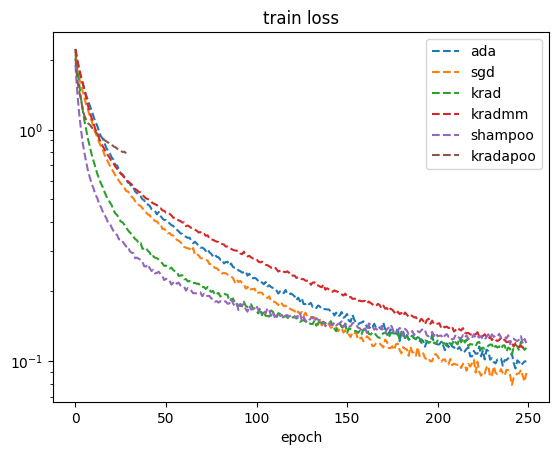

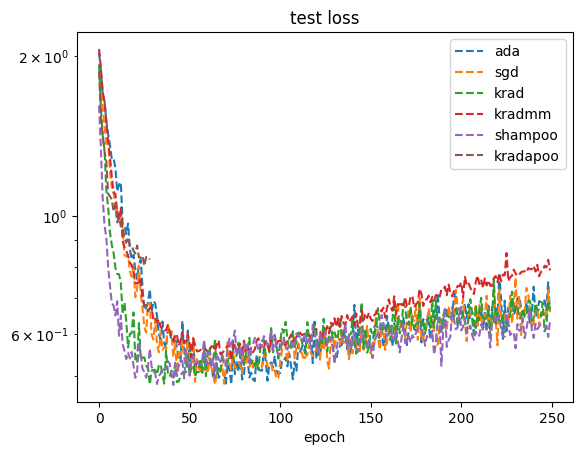

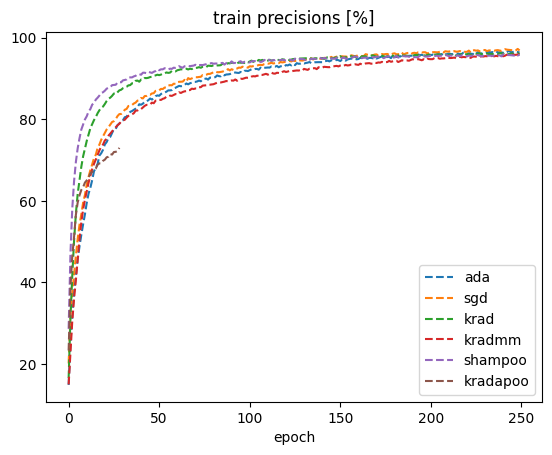

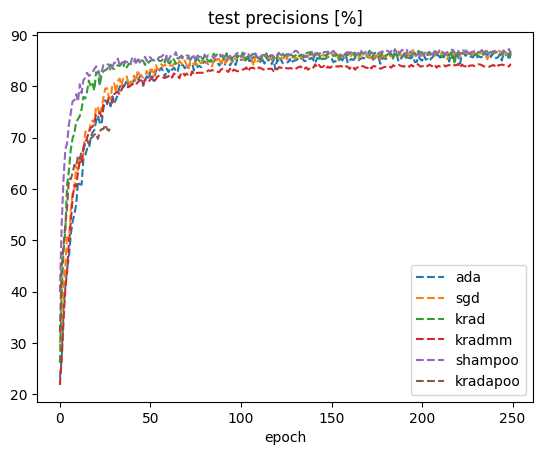

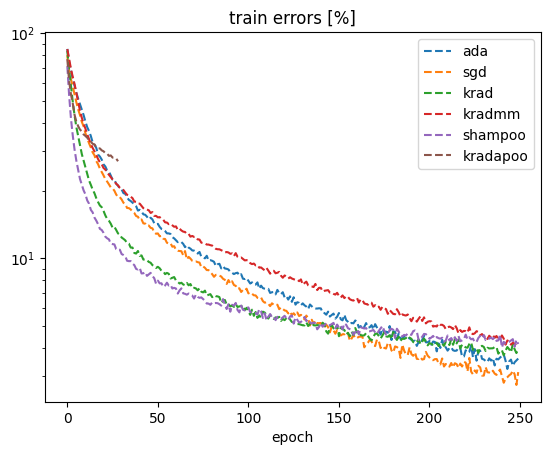

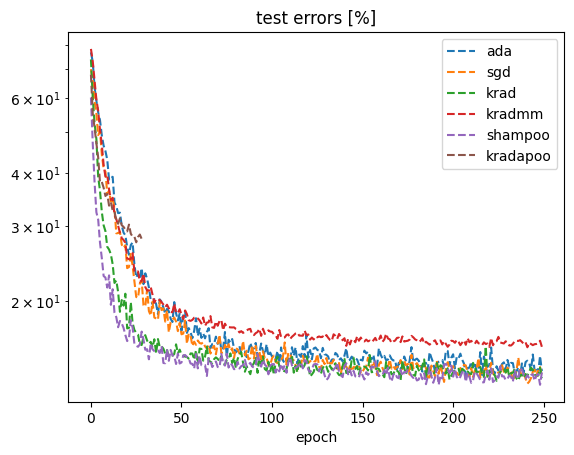

In [3]:
arch = 'resnet32'
data = 'CIFAR10'
modifier = ''
modifier = '_no_batchnorm'

hyperparams_to_sweep_precon = SimpleNamespace(
    optimizer=['kradmm', 'krad', 'shampoo', 'kradapoo'],  
    epochs=['250'],
    eps_str=['1e-4'],
    lr_str=['1', '2.5e-1', '1e-1', '2.5e-2', '1e-2'],
)

hyperparams_to_sweep_gd = SimpleNamespace(
    optimizer=['sgd'],
    epochs=['250'],
    eps_str=['1e-1'],
    lr_str=['1e-1', '5e-2', '2e-2', '1e-2', '5e-3', '2e-3', '1e-3'],
)


hyperparams_to_sweep_ada = SimpleNamespace(
    optimizer=['ada'],
    epochs=['250'],
    eps_str=['1e-1'],
    lr_str=['1e-1', '5e-2', '2e-2', '1e-2', '5e-3', '2e-3', '1e-3'],
)

loss_s, prec_s = fetch_loss_prec(arch, data, modifier, [
    hyperparams_to_sweep_precon, hyperparams_to_sweep_gd, hyperparams_to_sweep_ada
])
plot_all(loss_s, prec_s)

file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr1e-1_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr5e-2_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr2e-2_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr1e-2_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr5e-3_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr2e-3_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada_eps1e-1_lr1e-3_batch128.npy
['CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_ada.npy', 'CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/prec_ada.npy']
-> opt failed: ada
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_sgd_eps1e-1_lr1e-1_batch128.npy
file not found: CIFAR100_resnet56_nohalf_no_batchnorm_ckpts/loss_sgd_eps1e-1_lr5e-2_

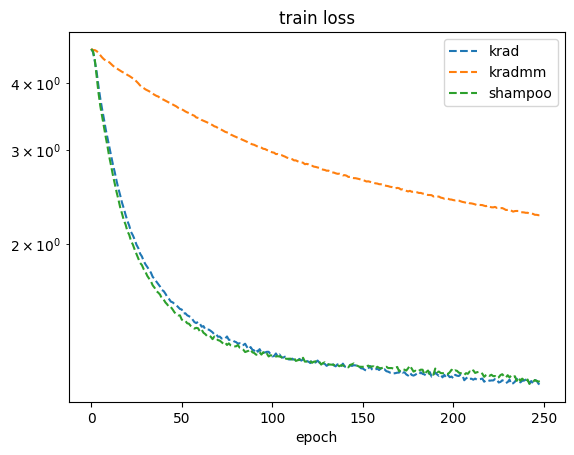

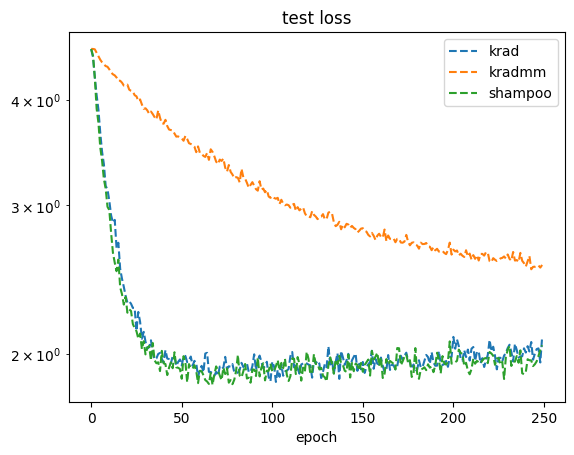

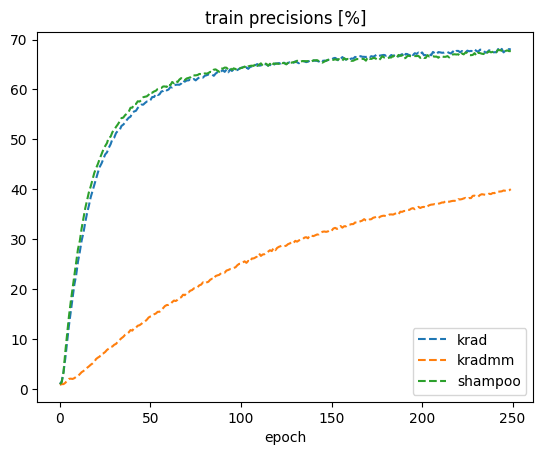

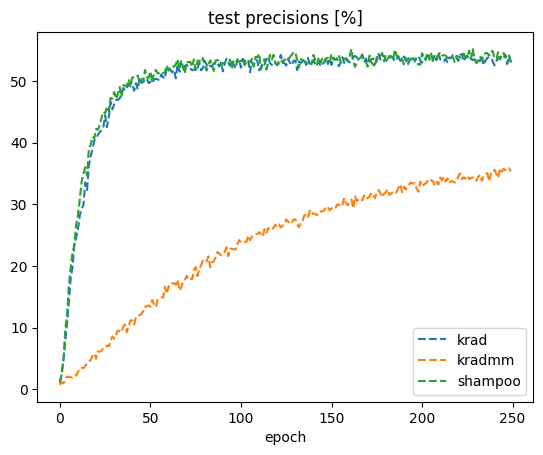

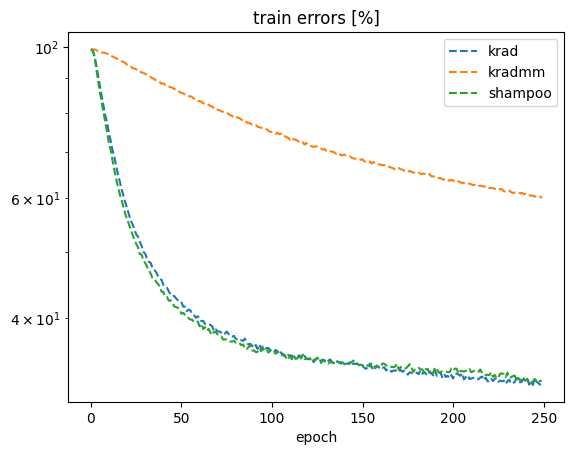

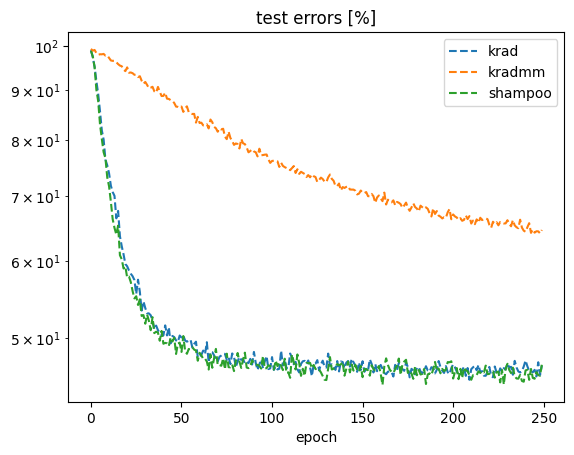

In [6]:
###without batchnorm:
arch = 'resnet56'; data = 'CIFAR100'; exp_modifier = '_nohalf_no_batchnorm'; fn_modifier = ''


###with batchnorm:
##backwards, from old naming convention
#arch='CIFAR100'; data='resnet56'; exp_modifier = ''; fn_modifier = '_relu'

hyperparams_to_sweep_precon = SimpleNamespace(
    optimizer=['kradmm', 'krad', 'shampoo'],  
    epochs=['250'],
    eps_str=['1e-4'],
    lr_str=['1', '2.5e-1', '1e-1', '2.5e-2', '1e-2'],
)

hyperparams_to_sweep_gd = SimpleNamespace(
    optimizer=['sgd'],
    epochs=['250'],
    eps_str=['1e-1'],
    lr_str=['1e-1', '5e-2', '2e-2', '1e-2', '5e-3', '2e-3', '1e-3'],
)


hyperparams_to_sweep_ada = SimpleNamespace(
    optimizer=['ada'],
    epochs=['250'],
    eps_str=['1e-1'],
    lr_str=['1e-1', '5e-2', '2e-2', '1e-2', '5e-3', '2e-3', '1e-3'],
)


loss_s, prec_s = fetch_loss_prec(arch, data, exp_modifier, [
    hyperparams_to_sweep_precon, hyperparams_to_sweep_gd, hyperparams_to_sweep_ada
], fn_modifier=fn_modifier)

#opts_to_plot = ['ada', 'sgd', 'shampoo', 'krad', 'kradmm']
plot_all(loss_s, prec_s)